# Simulation of Experiments
### new ads and mature ads, SBL-DMD, no long-term effects

In [1]:
# import packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from datetime import time, datetime
import datetime as dt
import statsmodels.api as sm
import argparse
import math
from time import time 
import random

In [2]:
#PID system for cold start, current practice on Platform O is uniformaly increasing
#bids of new ads, e.g., 3 times of target_bid, then let PID system dynamically change the bid
def PID_sys(current_cpc_, target_cpc_, current_ecpc_):
    #we use a simplified version of PID with 1) k_I=p_D=0, 2) set current_ecpc = current_cpc
    #which means the PID use an exponential smoothing to update bids
    k_p = 0.4
    
    #equivalent version:
    #error = target_cpc_ - current_ecpc_
    #current_cpc_updated = current_cpc_ + k_p*error
    
    current_cpc_updated = target_cpc_*k_p + current_cpc_*(1-k_p)
    
    return current_cpc_updated

In [3]:
#true CTR generating function (linear), we use fix effect models to get CTR constants for both 
#new ads and mature ads. But due to the data security, we do not disclose the joint distribution of 
#contexts information (features). Instead we only use marginal distribution of three
#demographic features including gender, location, and age, and synthetically generate the 
#corresponding coefficient of CTR linear model


#context generate function
gender_pdf = np.array([0.5, 0.5])#marginal distribution of gender. [male, female]
location_pdf = np.array([0.22, 0.46, 0.32])#marginal distribution of city level. [large city, medium city, small city]
age_seg_pdf = np.array([0.46, 0.34, 0.20])#distribution of age. [<24,  24~30, >30]
dim_context  = int(np.shape(gender_pdf)[0]+np.shape(location_pdf)[0]+np.shape(age_seg_pdf)[0] + 1)
def context_generate(gender_ratio = gender_pdf, loc_ratio = location_pdf, age_ratio = age_seg_pdf):
    a = np.random.multinomial(1, gender_pdf, size=1)
    b = np.random.multinomial(1, location_pdf, size=1)
    c = np.random.multinomial(1, age_ratio, size=1)
    return np.concatenate((a, b, c, 1), axis=None)#last one is constant 1 for fixed CTR

#load joint information of ctr fixed effect coefficient, and target bid (CPC)
ctr_bid_np = np.load('ctr_bid_data.npy')#we sampled 300 data points, the first column is CTR, the second is CPC
#note the first 200 rows are marure ads and last 100 rows are new ads
def generate_ad(n, new_raito = 0.30, dim_context = dim_context, data = ctr_bid_np):
    #n is the total number of ads, new_raito is ratio of new ads
    num_new_ad = int(n*new_raito)
    num_mature_ad = n - num_new_ad
    sampled_ctr = data[:, 0]
    sampled_cpc = data[:, 1]
    
    #initialize output data: 
    is_new_index = np.zeros(n)
    target_cpc = np.zeros(n)
    coefficient_ctr_model = np.zeros([n, dim_context])
    #generate bid, true CTR model
    for i in range(n):
        index = 0
        if i < num_mature_ad:
            is_new_index[i] = 0
            index = np.random.choice(np.arange(0,200))
        else:
            is_new_index[i] = 1
            index = np.random.choice(np.arange(200,300))
        
        target_cpc[i] = sampled_cpc[index]
        coefficient_ctr_model[i, 0:-1] = np.random.uniform(-0.05,0.05,dim_context-1)
        coefficient_ctr_model[i, -1] = sampled_ctr[index]
    return np.int32(is_new_index), target_cpc, coefficient_ctr_model

# Hyperparameter Setting

In [4]:
# hyperparameters settings: first price, CPC
import sys
sys.argv=['']
del sys
parser = argparse.ArgumentParser()

#Default cold start parameter - the cold start value = reward*I(clicks>=target_click)
parser.add_argument('--total_ads', type=int, default=1000, help='total number of ads for simulation')
parser.add_argument('--new_ad_ratio', type=float, default=0.3, help='ratio of new ads')
parser.add_argument('--total_pv', type=int, default=3000000, help='loaded total page views in one cold start horizon for simulation')
parser.add_argument('--reward', type=float, default=400000, help='reward of cold start')
parser.add_argument('--target_click', type=int, default=1000, help='target click')
parser.add_argument('--alpha', type=float, default=1e-3, help='target click/total_pv')


#conditions of ads to get ouf of the cold start phase
parser.add_argument('--budget_limit', type=int, default=5e5, help='set an uniform budget limit on ads')
#once new ads hit target click = 1000, it is labeled mature ads. this default budget is enough for cold start
parser.add_argument('--cs', type=int, default=1, help='if using SBL-DMD in parallel simulation')
parser.add_argument('--stepsize', type=float, default=30, help='step size of DMD')
parser.add_argument('--PID_cycle', type=int, default=100000, help='after every # pvs, update PID')




#two side exp parameters
parser.add_argument('--ad_treatment_ratio', type=float, default=0.4, help='range from 0 to 0.5')
parser.add_argument('--pv_treatment_ratio', type=float, default=0.4, help='range from 0 to 0.5')



opt = parser.parse_args()
opt.alpha  = opt.target_click/opt.total_pv




In [5]:

is_new_index, target_bid_price, coefficient_ctr_model = generate_ad(n = opt.total_ads, 
                                                                          new_raito = opt.new_ad_ratio)

## Part I: Two parallel simulation using PID or SBL-DMD

### I.1 PID baseline

In [24]:
opt.cs = 0#using PID

#lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
lambda_ = np.zeros(opt.total_ads)


beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
target_cpc = np.copy(target_bid_price)

total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
new_ad_index = np.where(is_new_index==1)[0]



#before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
#if using SBL-DMD, adding bonus bid lambda to target_cpc
current_cpc = np.zeros(opt.total_ads)
if opt.cs == 0:
    for i in range(opt.total_ads):
        if is_new_index[i]==1:
            current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click
      

            
#simulation starts
for i in range(opt.total_pv):

    ##########################generate context##########################
    contexts = context_generate()

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.zeros(opt.total_ads)
    pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
    if opt.cs == 1:
        current_bid_np = target_cpc + lambda_
    else:
        current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index#if using PID
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if opt.cs==1:
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        #using PID
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]

    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    if opt.cs==1:
        #SBL-DMD, using dual mirror descent to update lambda
        lambda_ += opt.stepsize*opt.alpha
        lambda_[max_index] -= opt.stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_index
        lambda_ = np.maximum(lambda_, 0)*is_new_index
        
        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
    if opt.cs==0 and i%opt.PID_cycle==(opt.PID_cycle-1):
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc, target_cpc, current_ecpc)
    current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc
    
   

In [25]:
#store the simulation results
total_clicks_pid = np.copy(total_clicks)
total_impressions_pid = np.copy(total_impressions)
total_cost_pid = np.copy(total_cost)
final_bid_pid = np.copy(current_cpc)
final_lambda_pid = np.copy(lambda_)

print('================================================')
print('Revenue:', np.sum(total_cost))
print('L1-Cold Start Reward:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))
print('Total Objective Value:', np.sum(total_cost)+np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))
print('================================================')
PO_c = (total_clicks*is_new_index>=opt.target_click).sum()/is_new_index.sum()#potential outcome in control, take Cold Start Success Rate as example
print('Cold Start Success Rate:',PO_c)
PO_rev_c = np.sum(total_cost)





Revenue: 78633011.68624978
L1-Cold Start Reward: 1449200.0
Total Objective Value: 80082211.68624978
Cold Start Success Rate: 0.0033333333333333335


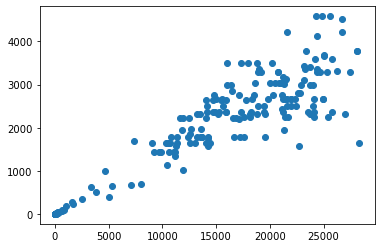

In [26]:
plt.scatter(total_impressions_pid, total_clicks_pid)

(array([294.,   2.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([     0.        ,  15606.15579604,  31212.31159207,  46818.46738811,
         62424.62318415,  78030.77898018,  93636.93477622, 109243.09057226,
        124849.24636829, 140455.40216433, 156061.55796037]),
 <BarContainer object of 10 artists>)

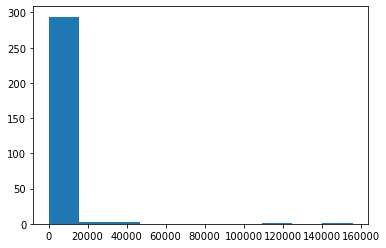

In [27]:
plt.hist(total_cost_pid[700:])

### I.2 SBL-DMD

In [28]:
opt.cs = 1#using SBL-DMD

#lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
target_cpc = np.copy(target_bid_price)



total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
new_ad_index = np.where(is_new_index==1)[0]



#before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
#if using SBL-DMD, adding bonus bid lambda to target_cpc
current_cpc = np.zeros(opt.total_ads)
if opt.cs == 0:
    lambda_ = np.zeros(opt.total_ads)
    for i in range(opt.total_ads):
        if is_new_index[i]==1:
            current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click
    
            
#simulation starts
for i in range(opt.total_pv):

    ##########################generate context##########################
    contexts = context_generate()

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.zeros(opt.total_ads)
    pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
    if opt.cs == 1:
        current_bid_np = target_cpc + lambda_
    else:
        current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index#if using PID
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if opt.cs==1:
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        #using PID
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]

    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    if opt.cs==1:
        #SBL-DMD, using dual mirror descent to update lambda
        lambda_ += opt.stepsize*opt.alpha
        lambda_[max_index] -= opt.stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_index
        lambda_ = np.maximum(lambda_, 0)*is_new_index
        
        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
    if opt.cs==0 and i%opt.PID_cycle==(opt.PID_cycle-1):
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
    current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc

    

In [29]:
#store the simulation results
total_clicks_sbl = np.copy(total_clicks)
total_impressions_sbl = np.copy(total_impressions)
total_cost_sbl = np.copy(total_cost)
final_bid_sbl = np.copy(current_cpc)
final_lambda_sbl = np.copy(lambda_)

print('================================================')
print('Revenue:', np.sum(total_cost))
print('L1-Cold Start Reward:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))
print('Total Objective Value:', np.sum(total_cost)+np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))
print('================================================')
PO_t = (total_clicks*is_new_index>=opt.target_click).sum()/is_new_index.sum()#potential outcome in treatment, take Cold Start Success Rate as example
print('Cold Start Success Rate:',PO_t)
PO_rev_t = np.sum(total_cost)


Revenue: 78360186.73119
L1-Cold Start Reward: 30848400.0
Total Objective Value: 109208586.73119
Cold Start Success Rate: 0.07666666666666666


In [30]:
print('Ground True Effect on Cold Start Success Rate:', PO_t-PO_c)
print('Ground True (Relative) Effect on Revenue:', '{:.1%}'.format(PO_rev_t/PO_rev_c-1))

Ground True Effect on Cold Start Success Rate: 0.07333333333333333
Ground True (Relative) Effect on Revenue: -0.3%


In [13]:
print('Ground True Effect on Cold Start Success Rate:', PO_t-PO_c)
print('Ground True (Relative) Effect on Revenue:', '{:.1%}'.format(PO_rev_t/PO_rev_c-1))

Ground True Effect on Cold Start Success Rate: 0.06666666666666667
Ground True (Relative) Effect on Revenue: -0.2%


# Part II: One side experiments

### II.1 Ad side experiments

In [31]:
opt.ad_treatment_ratio = 0.4


print('Ad side randomized experiment')
print('# of new ads in treatment condition (SBL-DMD)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
print('# of new ads in control condition (PID)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))

#randomly assign new ads into treatment and control groups
is_new_treatment = np.zeros(opt.total_ads)
is_new_control = np.zeros(opt.total_ads)

new_ad_index = np.where(is_new_index==1)[0]
treatment_new_ad_index = np.random.choice(new_ad_index, int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

control_new_ad_index = np.random.choice(np.setdiff1d(new_ad_index, treatment_new_ad_index), 
                                          int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

for i in range(int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio)):
    is_new_treatment[treatment_new_ad_index[i]] = 1
    is_new_control[control_new_ad_index[i]] = 1
    


#initialization
#lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
target_cpc = np.copy(target_bid_price)


total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067



#before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
#if using SBL-DMD, adding bonus bid lambda to target_cpc
current_cpc = np.zeros(opt.total_ads)
for i in range(opt.total_ads):
    if is_new_control[i] == 1:
        #new control ads
        current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click

            
#simulation starts
for i in range(opt.total_pv):

    ##########################generate context##########################
    contexts = context_generate()

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.copy(target_cpc)
    pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
    current_bid_np = current_bid_np*(1-is_new_control) + current_cpc*is_new_control + lambda_*is_new_treatment
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0

    if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
        max_index = np.random.choice(treatment_new_ad_index, 1)[0]
    else:
        max_index = np.argmax(ecpm, axis=0)

    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]

    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    #SBL-DMD, using dual mirror descent to update lambda
    lambda_ += opt.stepsize*opt.alpha
    lambda_[max_index] -= opt.stepsize*pCTR[max_index]

    #upper bound the bounus, and mature ads with 0 bonus
    lambda_ = np.minimum(lambda_, beta_)*is_new_treatment
    lambda_ = np.maximum(lambda_, 0)*is_new_treatment

    #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
    lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
    
    if i%opt.PID_cycle==(opt.PID_cycle-1):
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        current_cpc = current_cpc*is_new_control
    current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc

   

Ad side randomized experiment
# of new ads in treatment condition (SBL-DMD) 120
# of new ads in control condition (PID) 120


In [32]:
#store the simulation results
total_clicks_ad_side = np.copy(total_clicks)
total_impressions_ad_side = np.copy(total_impressions)
total_cost_ad_side = np.copy(total_cost)
final_bid_ad_side = np.copy(current_cpc)
final_lambda_ad_side = np.copy(lambda_)
is_new_treatment_ad_side = np.copy(is_new_treatment)
is_new_control_ad_side = np.copy(is_new_control)

print('================================================')
print('Revenue: In this ad-side design, revenue (over all auctions) diff between treatment and control cannot be identified because new ads in both conditions join all auctions.')
print('L1-Cold Start Reward in Treatment:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks*is_new_treatment, opt.target_click)))
print('L1-Cold Start Reward in Control:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks*is_new_control, opt.target_click)))
print('================================================')
a = (total_clicks*is_new_treatment>=opt.target_click).sum()/is_new_treatment.sum()
b = (total_clicks*is_new_control>=opt.target_click).sum()/is_new_control.sum()
print('Cold Start Success Rate in Treatment:', a)
print('Cold Start Success Rate in Control:', b)
print('Estimator of Effect on Cold Start Success Rate: ', a-b)
print('================================================')
print('Ground True Effect on Cold Start Success Rate:', PO_t-PO_c)
print('Overestimate/underestimate by:', '{:.1%}'.format((a-b)/(PO_t-PO_c)-1))




Revenue: In this ad-side design, revenue (over all auctions) diff between treatment and control cannot be identified because new ads in both conditions join all auctions.
L1-Cold Start Reward in Treatment: 15732400.0
L1-Cold Start Reward in Control: 1253600.0
Cold Start Success Rate in Treatment: 0.075
Cold Start Success Rate in Control: 0.016666666666666666
Estimator of Effect on Cold Start Success Rate:  0.058333333333333334
Ground True Effect on Cold Start Success Rate: 0.07333333333333333
Overestimate/underestimate by: -20.5%


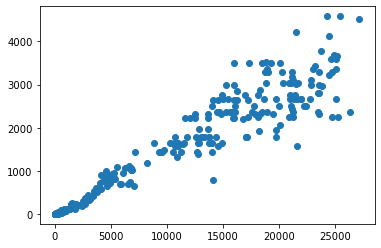

In [33]:
plt.scatter(total_impressions_ad_side, total_clicks_ad_side)

### II.2 UV side experiments

In [ ]:
opt.pv_treatment_ratio = 0.4

scaled_PID_cycle_length = int(opt.PID_cycle/opt.pv_treatment_ratio)


#lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
target_cpc = np.copy(target_bid_price)


total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_clicks_t = np.zeros(opt.total_ads)#accumulated number of clicks in treatment UVs
total_clicks_c = np.zeros(opt.total_ads)#accumulated number of clicks in control UVs

total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_impressions_t = np.zeros(opt.total_ads)#accumulated number of impressions in treatment UVs
total_impressions_c = np.zeros(opt.total_ads)#accumulated number of impressions in control UVs

total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
total_cost_t = np.zeros(opt.total_ads)
total_cost_c = np.zeros(opt.total_ads)

coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
new_ad_index = np.where(is_new_index==1)[0]



#before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
#if using SBL-DMD, adding bonus bid lambda to target_cpc
current_cpc = np.zeros(opt.total_ads)
for i in range(opt.total_ads):
    if is_new_index[i]==1:
        current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click


#simulation starts
for i in range(opt.total_pv):


    ##########################generate context##########################
    contexts = context_generate()
    uv_condition = np.random.choice(['t', 'c', 'ow'], 1, 
                                    p=[opt.pv_treatment_ratio, opt.pv_treatment_ratio, 1-2*opt.pv_treatment_ratio])[0]

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.zeros(opt.total_ads)
    pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
    if uv_condition == 't':
        current_bid_np = target_cpc + lambda_*is_new_index
    elif uv_condition == 'c':
        current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index
    else:
        current_bid_np = np.copy(target_cpc)
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    if uv_condition == 't':
        current_bid_np -= 10000*np.greater(total_cost_t, opt.pv_treatment_ratio*opt.budget_limit)*is_new_index
    elif uv_condition == 'c':
        current_bid_np -= 10000*np.greater(total_cost_c, opt.pv_treatment_ratio*opt.budget_limit)*is_new_index
    
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if uv_condition == 't':
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    if uv_condition == 't':
        total_impressions_t[max_index] += 1
    elif uv_condition == 'c':
        total_impressions_c[max_index] += 1
    #get the click feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]
        if uv_condition == 't':
            total_clicks_t[max_index] += 1
            total_cost_t[max_index] += target_cpc[max_index]
        elif uv_condition == 'c':
            total_clicks_c[max_index] += 1
            total_cost_c[max_index] += target_cpc[max_index]
    
    
    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    if uv_condition == 't':
        #SBL-DMD, using dual mirror descent to update lambda
        lambda_ += opt.stepsize*opt.alpha
        lambda_[max_index] -= opt.stepsize*pCTR[max_index]
        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_index
        lambda_ = np.maximum(lambda_, 0)*is_new_index
        lambda_ = np.less(total_clicks_t, opt.pv_treatment_ratio*opt.target_click*np.ones(opt.total_ads))*lambda_
    #if i%scaled_PID_cycle_length==(scaled_PID_cycle_length-1):
    if i%opt.PID_cycle==(opt.PID_cycle-1):
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        current_cpc = current_cpc*is_new_index
    if uv_condition == 'c':
        current_cpc = np.less(total_clicks_c, opt.pv_treatment_ratio*opt.target_click)*current_cpc + (1- np.less(total_clicks_c, opt.pv_treatment_ratio*opt.target_click))*target_cpc



In [ ]:
#store the simulation results

#if i%opt.PID_cycle==(opt.PID_cycle-1):

total_clicks_uv_side = np.copy(total_clicks)
total_impressions_uv_side = np.copy(total_impressions)
total_cost_uv_side = np.copy(total_cost)
final_bid_uv_side = np.copy(current_cpc)
final_lambda_uv_side = np.copy(lambda_)

print('================================================')
print('Revenue in Treatment with ', opt.pv_treatment_ratio, ' of total impressions:', np.sum(total_cost_t))
print('Revenue in Control with ', opt.pv_treatment_ratio, ' of total impressions:', np.sum(total_cost_c))
print('L1-Cold Start Reward in Treatment:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_t*is_new_index, opt.pv_treatment_ratio*opt.target_click)))
print('L1-Cold Start Reward in Control:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_c*is_new_index, opt.pv_treatment_ratio*opt.target_click)))
print('================================================')
a = (total_clicks_t*is_new_index>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_index.sum()
b = (total_clicks_c*is_new_index>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_index.sum()
print('Cold Start Success Rate in Treatment:', a)
print('Cold Start Success Rate in Control:', b)
print('Estimator of Effect on Cold Start Success Rate: ', a-b)
print('================================================')
print('Ground True Effect on Cold Start Success Rate:', PO_t-PO_c)
print('Overestimate/underestimate by:', '{:.1%}'.format((a-b)/(PO_t-PO_c)-1))
print('================================================')
print('Estimator of (Relative) Effect on Revenue:', '{:.1%}'.format(np.sum(total_cost_t)/np.sum(total_cost_c)-1))
print('Ground True (Relative) Effect on Revenue:', '{:.1%}'.format(PO_rev_t/PO_rev_c-1))


# Part III: Two side experiments

In [ ]:
opt.ad_treatment_ratio = 0.4
opt.pv_treatment_ratio = 0.4



print('Two side randomized experiment')
print('# of new ads in treatment condition (SBL-DMD)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
print('# of new ads in control condition (PID)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
scaled_PID_cycle_length = int(opt.PID_cycle/opt.pv_treatment_ratio)

#randomly assign new ads into treatment and control groups
is_new_treatment = np.zeros(opt.total_ads)
is_new_control = np.zeros(opt.total_ads)

new_ad_index = np.where(is_new_index==1)[0]
treatment_new_ad_index = np.random.choice(new_ad_index, int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

control_new_ad_index = np.random.choice(np.setdiff1d(new_ad_index, treatment_new_ad_index), 
                                          int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

for i in range(int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio)):
    is_new_treatment[treatment_new_ad_index[i]] = 1
    is_new_control[control_new_ad_index[i]] = 1
    

#lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
target_cpc = np.copy(target_bid_price)



total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_impressions_two_t = np.zeros(opt.total_ads)#accumulated number of impressions in treatment UVs & ads
total_impressions_two_c = np.zeros(opt.total_ads)#accumulated number of impressions in control UVs & ads
total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_clicks_two_t = np.zeros(opt.total_ads)#accumulated number of clicks in treatment UVs & ads
total_clicks_two_c = np.zeros(opt.total_ads)#accumulated number of clicks in control UVs & ads
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
total_cost_two_t = np.zeros(opt.total_ads)
total_cost_two_c = np.zeros(opt.total_ads)

coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067



#before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
#if using SBL-DMD, adding bonus bid lambda to target_cpc
current_cpc = np.zeros(opt.total_ads)
for i in range(opt.total_ads):
    if is_new_control[i] == 1:
        #new control ads
        current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click

            
#simulation starts
for i in range(opt.total_pv):


    ##########################generate context##########################
    contexts = context_generate()
    uv_condition = np.random.choice(['t', 'c', 'ow'], 1, 
                                p=[opt.pv_treatment_ratio, opt.pv_treatment_ratio, 1-2*opt.pv_treatment_ratio])[0]



    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.copy(target_cpc)
    pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
    if uv_condition == 't':
        #block ads in control condition by setting bid=-10000
        current_bid_np = current_bid_np*(1-is_new_control) - 10000*is_new_control + lambda_*is_new_treatment
    elif uv_condition == 'c':
        #block ads in treatment condition
        current_bid_np = current_bid_np*(1-is_new_control) + current_cpc*is_new_control - 10000*is_new_treatment
    else:
        current_bid_np = current_bid_np - 10000*is_new_control - 10000*is_new_treatment
    
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    if uv_condition == 't':
        current_bid_np -= 10000*np.greater(total_cost_two_t, opt.pv_treatment_ratio*opt.budget_limit)*is_new_treatment
    elif uv_condition == 'c':
        current_bid_np -= 10000*np.greater(total_cost_two_c, opt.pv_treatment_ratio*opt.budget_limit)*is_new_control
    #    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if uv_condition == 't':
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(treatment_new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    if uv_condition == 't':
        total_impressions_two_t[max_index] += 1
    elif uv_condition == 'c':
        total_impressions_two_c[max_index] += 1
        
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]
        if uv_condition == 't':
            total_clicks_two_t[max_index] += 1
            total_cost_two_t[max_index] += target_cpc[max_index]
        elif uv_condition == 'c':
            total_clicks_two_c[max_index] += 1
            total_cost_two_c[max_index] += target_cpc[max_index]


    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    #SBL-DMD, using dual mirror descent to update lambda
    if uv_condition == 't':
        lambda_ += opt.stepsize*opt.alpha
        lambda_[max_index] -= opt.stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_treatment
        lambda_ = np.maximum(lambda_, 0)*is_new_treatment

        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks_two_t, opt.pv_treatment_ratio*opt.target_click*np.ones(opt.total_ads))*lambda_
    
    if i%opt.PID_cycle==(opt.PID_cycle-1):
    #if i%scaled_PID_cycle_length==(scaled_PID_cycle_length-1):
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        current_cpc = current_cpc*is_new_control
    if uv_condition == 'c':
        current_cpc = np.less(total_clicks_two_c, opt.pv_treatment_ratio*opt.target_click)*current_cpc + (1- np.less(total_clicks_two_c, opt.pv_treatment_ratio*opt.target_click))*target_cpc

    
   

In [ ]:
#store the simulation results
total_clicks_two_side = np.copy(total_clicks)
total_impressions_two_side = np.copy(total_impressions)
total_cost_two_side = np.copy(total_cost)
final_bid_two_side = np.copy(current_cpc)
final_lambda_two_side = np.copy(lambda_)
is_new_treatment_two_side = np.copy(is_new_treatment)
is_new_control_two_side = np.copy(is_new_control)


print('================================================')
print('Revenue in Treatment with ', opt.pv_treatment_ratio, ' of total impressions:', np.sum(total_cost_two_t))
print('Revenue in Control with ', opt.pv_treatment_ratio, ' of total impressions:', np.sum(total_cost_two_c))
print('L1-Cold Start Reward in Treatment:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_two_t*is_new_treatment, opt.pv_treatment_ratio*opt.target_click)))
print('L1-Cold Start Reward in Control:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_two_c*is_new_control, opt.pv_treatment_ratio*opt.target_click)))
print('================================================')
a = (total_clicks_two_t*is_new_treatment>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_treatment.sum()
b = (total_clicks_two_c*is_new_control>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_control.sum()
print('Cold Start Success Rate in Treatment:', a)
print('Cold Start Success Rate in Control:', b)
print('Estimator of Effect on Cold Start Success Rate: ', a-b)
print('Ground True Effect on Cold Start Success Rate:', PO_t-PO_c)
print('Overestimate/underestimate by:', '{:.1%}'.format((a-b)/(PO_t-PO_c)-1))
print('================================================')
print('Estimator of (Relative) Effect on Revenue:', '{:.1%}'.format(np.sum(total_cost_two_t)/np.sum(total_cost_two_c)-1))
print('Ground True (Relative) Effect on Revenue:', '{:.1%}'.format(PO_rev_t/PO_rev_c-1))

In [ ]:
opt.ad_treatment_ratio = 0.2
opt.pv_treatment_ratio = 0.33



print('Two side randomized experiment')
print('# of new ads in treatment condition (SBL-DMD)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
print('# of new ads in control condition (PID)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
scaled_PID_cycle_length = int(opt.PID_cycle/opt.pv_treatment_ratio)

#randomly assign new ads into treatment and control groups
is_new_treatment = np.zeros(opt.total_ads)
is_new_control = np.zeros(opt.total_ads)

new_ad_index = np.where(is_new_index==1)[0]
treatment_new_ad_index = np.random.choice(new_ad_index, int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

control_new_ad_index = np.random.choice(np.setdiff1d(new_ad_index, treatment_new_ad_index), 
                                          int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

for i in range(int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio)):
    is_new_treatment[treatment_new_ad_index[i]] = 1
    is_new_control[control_new_ad_index[i]] = 1
    

#lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
target_cpc = np.copy(target_bid_price)



total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_impressions_two_t = np.zeros(opt.total_ads)#accumulated number of impressions in treatment UVs & ads
total_impressions_two_c = np.zeros(opt.total_ads)#accumulated number of impressions in control UVs & ads
total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_clicks_two_t = np.zeros(opt.total_ads)#accumulated number of clicks in treatment UVs & ads
total_clicks_two_c = np.zeros(opt.total_ads)#accumulated number of clicks in control UVs & ads
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
total_cost_two_t = np.zeros(opt.total_ads)
total_cost_two_c = np.zeros(opt.total_ads)

coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067



#before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
#if using SBL-DMD, adding bonus bid lambda to target_cpc
current_cpc = np.zeros(opt.total_ads)
for i in range(opt.total_ads):
    if is_new_control[i] == 1:
        #new control ads
        current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click

            
#simulation starts
for i in range(opt.total_pv):


    ##########################generate context##########################
    contexts = context_generate()
    uv_condition = np.random.choice(['t', 'c', 'ow'], 1, 
                                p=[opt.pv_treatment_ratio, opt.pv_treatment_ratio, 1-2*opt.pv_treatment_ratio])[0]



    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.copy(target_cpc)
    pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
    if uv_condition == 't':
        #block ads in control condition by setting bid=-10000
        current_bid_np = current_bid_np*(1-is_new_control) - 10000*is_new_control + lambda_*is_new_treatment
    elif uv_condition == 'c':
        #block ads in treatment condition
        current_bid_np = current_bid_np*(1-is_new_control) + current_cpc*is_new_control - 10000*is_new_treatment
    else:
        current_bid_np = current_bid_np - 10000*is_new_control - 10000*is_new_treatment
    
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    if uv_condition == 't':
        current_bid_np -= 10000*np.greater(total_cost_two_t, opt.pv_treatment_ratio*opt.budget_limit)*is_new_treatment
    elif uv_condition == 'c':
        current_bid_np -= 10000*np.greater(total_cost_two_c, opt.pv_treatment_ratio*opt.budget_limit)*is_new_control
    #    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if uv_condition == 't':
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(treatment_new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    if uv_condition == 't':
        total_impressions_two_t[max_index] += 1
    elif uv_condition == 'c':
        total_impressions_two_c[max_index] += 1
        
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]
        if uv_condition == 't':
            total_clicks_two_t[max_index] += 1
            total_cost_two_t[max_index] += target_cpc[max_index]
        elif uv_condition == 'c':
            total_clicks_two_c[max_index] += 1
            total_cost_two_c[max_index] += target_cpc[max_index]


    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    #SBL-DMD, using dual mirror descent to update lambda
    if uv_condition == 't':
        lambda_ += opt.stepsize*opt.alpha
        lambda_[max_index] -= opt.stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_treatment
        lambda_ = np.maximum(lambda_, 0)*is_new_treatment

        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks_two_t, opt.pv_treatment_ratio*opt.target_click*np.ones(opt.total_ads))*lambda_
    
    #if i%opt.PID_cycle==(opt.PID_cycle-1):
    if i%scaled_PID_cycle_length==(scaled_PID_cycle_length-1):
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        current_cpc = current_cpc*is_new_control
    if uv_condition == 'c':
        current_cpc = np.less(total_clicks_two_c, opt.pv_treatment_ratio*opt.target_click)*current_cpc + (1- np.less(total_clicks_two_c, opt.pv_treatment_ratio*opt.target_click))*target_cpc

    
   

In [ ]:
#store the simulation results
total_clicks_two_side = np.copy(total_clicks)
total_impressions_two_side = np.copy(total_impressions)
total_cost_two_side = np.copy(total_cost)
final_bid_two_side = np.copy(current_cpc)
final_lambda_two_side = np.copy(lambda_)
is_new_treatment_two_side = np.copy(is_new_treatment)
is_new_control_two_side = np.copy(is_new_control)


print('================================================')
print('Revenue in Treatment with ', opt.pv_treatment_ratio, ' of total impressions:', np.sum(total_cost_two_t))
print('Revenue in Control with ', opt.pv_treatment_ratio, ' of total impressions:', np.sum(total_cost_two_c))
print('L1-Cold Start Reward in Treatment:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_two_t*is_new_treatment, opt.pv_treatment_ratio*opt.target_click)))
print('L1-Cold Start Reward in Control:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_two_c*is_new_control, opt.pv_treatment_ratio*opt.target_click)))
print('================================================')
a = (total_clicks_two_t*is_new_treatment>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_treatment.sum()
b = (total_clicks_two_c*is_new_control>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_control.sum()
print('Cold Start Success Rate in Treatment:', a)
print('Cold Start Success Rate in Control:', b)
print('Estimator of Effect on Cold Start Success Rate: ', a-b)
print('================================================')
print('Ground True Effect on Cold Start Success Rate:', PO_t-PO_c)
print('Overestimate/underestimate by:', '{:.1%}'.format((a-b)/(PO_t-PO_c)-1))
print('================================================')
print('Estimator of (Relative) Effect on Revenue:', '{:.1%}'.format(np.sum(total_cost_two_t)/np.sum(total_cost_two_c)-1))
print('Ground True (Relative) Effect on Revenue:', '{:.1%}'.format(PO_rev_t/PO_rev_c-1))



# Replications - T-test

In [8]:
replication_times = 10
opt = parser.parse_args()
opt.alpha  = opt.target_click/opt.total_pv
is_new_index, target_bid_price, coefficient_ctr_model = generate_ad(n = opt.total_ads, 
                                                                          new_raito = opt.new_ad_ratio)

true_cs_value = []
ad_side_cs_estimator = []
uv_side_cs_estimator = []
two_side_cs_estimator = []

for rep_index in range(replication_times):
    
    print('Replication time: ', rep_index+1)

    
    opt.cs = 0#using PID

    #lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
    lambda_ = np.zeros(opt.total_ads)


    beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
    target_cpc = np.copy(target_bid_price)

    total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
    total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
    total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
    coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
    #assume for mature ads, we know exactly the true CTR model
    for i in range(opt.total_ads):
        if is_new_index[i]==0:
            coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
        else:
            #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
            #to mimic real situation, reco sys has partial prior knowledge of new ads
            #typically initialize by avergae over all ads with the same industry
            coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
    new_ad_index = np.where(is_new_index==1)[0]



    #before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
    #if using SBL-DMD, adding bonus bid lambda to target_cpc
    current_cpc = np.zeros(opt.total_ads)
    if opt.cs == 0:
        for i in range(opt.total_ads):
            if is_new_index[i]==1:
                current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click



    #simulation starts
    for i in range(opt.total_pv):

        ##########################generate context##########################
        contexts = context_generate()

        ##########################calculate eCPM and Auction##########################
        #calculate pCTR and eCPM = pCTR*bid
        current_bid_np = np.zeros(opt.total_ads)
        pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
        if opt.cs == 1:
            current_bid_np = target_cpc + lambda_
        else:
            current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index#if using PID
        current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
        ecpm = pCTR * current_bid_np
        #ranking
        max_index = 0
        if opt.cs==1:
            #exploration and exploitation
            if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
                max_index = np.random.choice(new_ad_index, 1)[0]
            else:
                max_index = np.argmax(ecpm, axis=0)
        else:
            #using PID
            max_index = np.argmax(ecpm, axis=0)


        ##########################click feedback and cost reduction##########################  
        total_impressions[max_index] += 1
        #get the feedback
        real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
        is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
        if is_clicked == 1:#if clicked
            total_clicks[max_index] += 1
            total_cost[max_index] += target_cpc[max_index]

        ##########################update pCTR prediction model##########################
        if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
            coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models

        ##########################update lambda or PID##########################
        if opt.cs==1:
            #SBL-DMD, using dual mirror descent to update lambda
            lambda_ += opt.stepsize*opt.alpha
            lambda_[max_index] -= opt.stepsize*pCTR[max_index]

            #upper bound the bounus, and mature ads with 0 bonus
            lambda_ = np.minimum(lambda_, beta_)*is_new_index
            lambda_ = np.maximum(lambda_, 0)*is_new_index

            #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
            lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
        if opt.cs==0 and i%opt.PID_cycle==(opt.PID_cycle-1):
            #using PID system to update current bid
            current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
            current_cpc = PID_sys(current_cpc, target_cpc, current_ecpc)
        current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc

    PO_c = (total_clicks*is_new_index>=opt.target_click).sum()/is_new_index.sum()#potential outcome in control, take Cold Start Success Rate as example



    opt.cs = 1#using SBL-DMD

    #lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
    lambda_ = np.zeros(opt.total_ads)
    beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
    target_cpc = np.copy(target_bid_price)



    total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
    total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
    total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
    coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
    #assume for mature ads, we know exactly the true CTR model
    for i in range(opt.total_ads):
        if is_new_index[i]==0:
            coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
        else:
            #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
            #to mimic real situation, reco sys has partial prior knowledge of new ads
            #typically initialize by avergae over all ads with the same industry
            coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
    new_ad_index = np.where(is_new_index==1)[0]



    #before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
    #if using SBL-DMD, adding bonus bid lambda to target_cpc
    current_cpc = np.zeros(opt.total_ads)
    if opt.cs == 0:
        lambda_ = np.zeros(opt.total_ads)
        for i in range(opt.total_ads):
            if is_new_index[i]==1:
                current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click


    #simulation starts
    for i in range(opt.total_pv):

        ##########################generate context##########################
        contexts = context_generate()

        ##########################calculate eCPM and Auction##########################
        #calculate pCTR and eCPM = pCTR*bid
        current_bid_np = np.zeros(opt.total_ads)
        pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
        if opt.cs == 1:
            current_bid_np = target_cpc + lambda_
        else:
            current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index#if using PID
        current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
        ecpm = pCTR * current_bid_np
        #ranking
        max_index = 0
        if opt.cs==1:
            #exploration and exploitation
            if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
                max_index = np.random.choice(new_ad_index, 1)[0]
            else:
                max_index = np.argmax(ecpm, axis=0)
        else:
            #using PID
            max_index = np.argmax(ecpm, axis=0)


        ##########################click feedback and cost reduction##########################  
        total_impressions[max_index] += 1
        #get the feedback
        real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
        is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
        if is_clicked == 1:#if clicked
            total_clicks[max_index] += 1
            total_cost[max_index] += target_cpc[max_index]

        ##########################update pCTR prediction model##########################
        if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
            coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models

        ##########################update lambda or PID##########################
        if opt.cs==1:
            #SBL-DMD, using dual mirror descent to update lambda
            lambda_ += opt.stepsize*opt.alpha
            lambda_[max_index] -= opt.stepsize*pCTR[max_index]

            #upper bound the bounus, and mature ads with 0 bonus
            lambda_ = np.minimum(lambda_, beta_)*is_new_index
            lambda_ = np.maximum(lambda_, 0)*is_new_index

            #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
            lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
        if opt.cs==0 and i%opt.PID_cycle==(opt.PID_cycle-1):
            #using PID system to update current bid
            current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
            current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc

    PO_t = (total_clicks*is_new_index>=opt.target_click).sum()/is_new_index.sum()#potential outcome in treatment, take Cold Start Success Rate as example

    true_cs_value.append(PO_t-PO_c)

    opt.ad_treatment_ratio = 0.4


    print('Ad side randomized experiment')
    print('# of new ads in treatment condition (SBL-DMD)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
    print('# of new ads in control condition (PID)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))

    #randomly assign new ads into treatment and control groups
    is_new_treatment = np.zeros(opt.total_ads)
    is_new_control = np.zeros(opt.total_ads)

    new_ad_index = np.where(is_new_index==1)[0]
    treatment_new_ad_index = np.random.choice(new_ad_index, int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

    control_new_ad_index = np.random.choice(np.setdiff1d(new_ad_index, treatment_new_ad_index), 
                                              int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

    for i in range(int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio)):
        is_new_treatment[treatment_new_ad_index[i]] = 1
        is_new_control[control_new_ad_index[i]] = 1



    #initialization
    #lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
    lambda_ = np.zeros(opt.total_ads)
    beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
    target_cpc = np.copy(target_bid_price)


    total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
    total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
    total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
    coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
    #assume for mature ads, we know exactly the true CTR model
    for i in range(opt.total_ads):
        if is_new_index[i]==0:
            coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
        else:
            #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
            #to mimic real situation, reco sys has partial prior knowledge of new ads
            #typically initialize by avergae over all ads with the same industry
            coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067



    #before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
    #if using SBL-DMD, adding bonus bid lambda to target_cpc
    current_cpc = np.zeros(opt.total_ads)
    for i in range(opt.total_ads):
        if is_new_control[i] == 1:
            #new control ads
            current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click


    #simulation starts
    for i in range(opt.total_pv):

        ##########################generate context##########################
        contexts = context_generate()

        ##########################calculate eCPM and Auction##########################
        #calculate pCTR and eCPM = pCTR*bid
        current_bid_np = np.copy(target_cpc)
        pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
        current_bid_np = current_bid_np*(1-is_new_control) + current_cpc*is_new_control + lambda_*is_new_treatment
        current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
        ecpm = pCTR * current_bid_np
        #ranking
        max_index = 0

        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(treatment_new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)


        ##########################click feedback and cost reduction##########################  
        total_impressions[max_index] += 1
        #get the feedback
        real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
        is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
        if is_clicked == 1:#if clicked
            total_clicks[max_index] += 1
            total_cost[max_index] += target_cpc[max_index]

        ##########################update pCTR prediction model##########################
        if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
            coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models

        ##########################update lambda or PID##########################
        #SBL-DMD, using dual mirror descent to update lambda
        lambda_ += opt.stepsize*opt.alpha
        lambda_[max_index] -= opt.stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_treatment
        lambda_ = np.maximum(lambda_, 0)*is_new_treatment

        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_

        if i%opt.PID_cycle==(opt.PID_cycle-1):
            #using PID system to update current bid
            current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
            current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
            current_cpc = current_cpc*is_new_control
        current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc

    a = (total_clicks*is_new_treatment>=opt.target_click).sum()/is_new_treatment.sum()
    b = (total_clicks*is_new_control>=opt.target_click).sum()/is_new_control.sum()
    ad_side_cs_estimator.append(a-b)

    opt.pv_treatment_ratio = 0.4

    scaled_PID_cycle_length = int(opt.PID_cycle/opt.pv_treatment_ratio)


    #lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
    lambda_ = np.zeros(opt.total_ads)
    beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
    target_cpc = np.copy(target_bid_price)


    total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
    total_clicks_t = np.zeros(opt.total_ads)#accumulated number of clicks in treatment UVs
    total_clicks_c = np.zeros(opt.total_ads)#accumulated number of clicks in control UVs

    total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
    total_impressions_t = np.zeros(opt.total_ads)#accumulated number of impressions in treatment UVs
    total_impressions_c = np.zeros(opt.total_ads)#accumulated number of impressions in control UVs

    total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
    total_cost_t = np.zeros(opt.total_ads)
    total_cost_c = np.zeros(opt.total_ads)

    coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
    #assume for mature ads, we know exactly the true CTR model
    for i in range(opt.total_ads):
        if is_new_index[i]==0:
            coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
        else:
            #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
            #to mimic real situation, reco sys has partial prior knowledge of new ads
            #typically initialize by avergae over all ads with the same industry
            coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
    new_ad_index = np.where(is_new_index==1)[0]



    #before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
    #if using SBL-DMD, adding bonus bid lambda to target_cpc
    current_cpc = np.zeros(opt.total_ads)
    for i in range(opt.total_ads):
        if is_new_index[i]==1:
            current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click


    #simulation starts
    for i in range(opt.total_pv):


        ##########################generate context##########################
        contexts = context_generate()
        uv_condition = np.random.choice(['t', 'c', 'ow'], 1, 
                                        p=[opt.pv_treatment_ratio, opt.pv_treatment_ratio, 1-2*opt.pv_treatment_ratio])[0]

        ##########################calculate eCPM and Auction##########################
        #calculate pCTR and eCPM = pCTR*bid
        current_bid_np = np.zeros(opt.total_ads)
        pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
        if uv_condition == 't':
            current_bid_np = target_cpc + lambda_*is_new_index
        elif uv_condition == 'c':
            current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index
        else:
            current_bid_np = np.copy(target_cpc)
        current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
        if uv_condition == 't':
            current_bid_np -= 10000*np.greater(total_cost_t, opt.pv_treatment_ratio*opt.budget_limit)*is_new_index
        elif uv_condition == 'c':
            current_bid_np -= 10000*np.greater(total_cost_c, opt.pv_treatment_ratio*opt.budget_limit)*is_new_index

        ecpm = pCTR * current_bid_np
        #ranking
        max_index = 0
        if uv_condition == 't':
            #exploration and exploitation
            if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
                max_index = np.random.choice(new_ad_index, 1)[0]
            else:
                max_index = np.argmax(ecpm, axis=0)
        else:
            max_index = np.argmax(ecpm, axis=0)


        ##########################click feedback and cost reduction##########################  
        total_impressions[max_index] += 1
        if uv_condition == 't':
            total_impressions_t[max_index] += 1
        elif uv_condition == 'c':
            total_impressions_c[max_index] += 1
        #get the click feedback
        real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
        is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
        if is_clicked == 1:#if clicked
            total_clicks[max_index] += 1
            total_cost[max_index] += target_cpc[max_index]
            if uv_condition == 't':
                total_clicks_t[max_index] += 1
                total_cost_t[max_index] += target_cpc[max_index]
            elif uv_condition == 'c':
                total_clicks_c[max_index] += 1
                total_cost_c[max_index] += target_cpc[max_index]


        ##########################update pCTR prediction model##########################
        if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
            coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models

        ##########################update lambda or PID##########################
        if uv_condition == 't':
            #SBL-DMD, using dual mirror descent to update lambda
            lambda_ += opt.stepsize*opt.alpha
            lambda_[max_index] -= opt.stepsize*pCTR[max_index]
            #upper bound the bounus, and mature ads with 0 bonus
            lambda_ = np.minimum(lambda_, beta_)*is_new_index
            lambda_ = np.maximum(lambda_, 0)*is_new_index
            lambda_ = np.less(total_clicks_t, opt.pv_treatment_ratio*opt.target_click*np.ones(opt.total_ads))*lambda_
        #if i%scaled_PID_cycle_length==(scaled_PID_cycle_length-1):
        if i%opt.PID_cycle==(opt.PID_cycle-1):
            #using PID system to update current bid
            current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
            current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
            current_cpc = current_cpc*is_new_index
        if uv_condition == 'c':
            current_cpc = np.less(total_clicks_c, opt.pv_treatment_ratio*opt.target_click)*current_cpc + (1- np.less(total_clicks_c, opt.pv_treatment_ratio*opt.target_click))*target_cpc


    a = (total_clicks_t*is_new_index>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_index.sum()
    b = (total_clicks_c*is_new_index>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_index.sum()
    uv_side_cs_estimator.append(a-b)

    opt.ad_treatment_ratio = 0.4
    opt.pv_treatment_ratio = 0.4



    print('Two side randomized experiment')
    print('# of new ads in treatment condition (SBL-DMD)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
    print('# of new ads in control condition (PID)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
    scaled_PID_cycle_length = int(opt.PID_cycle/opt.pv_treatment_ratio)

    #randomly assign new ads into treatment and control groups
    is_new_treatment = np.zeros(opt.total_ads)
    is_new_control = np.zeros(opt.total_ads)

    new_ad_index = np.where(is_new_index==1)[0]
    treatment_new_ad_index = np.random.choice(new_ad_index, int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

    control_new_ad_index = np.random.choice(np.setdiff1d(new_ad_index, treatment_new_ad_index), 
                                              int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

    for i in range(int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio)):
        is_new_treatment[treatment_new_ad_index[i]] = 1
        is_new_control[control_new_ad_index[i]] = 1


    #lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
    lambda_ = np.zeros(opt.total_ads)
    beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
    target_cpc = np.copy(target_bid_price)



    total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
    total_impressions_two_t = np.zeros(opt.total_ads)#accumulated number of impressions in treatment UVs & ads
    total_impressions_two_c = np.zeros(opt.total_ads)#accumulated number of impressions in control UVs & ads
    total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
    total_clicks_two_t = np.zeros(opt.total_ads)#accumulated number of clicks in treatment UVs & ads
    total_clicks_two_c = np.zeros(opt.total_ads)#accumulated number of clicks in control UVs & ads
    total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
    total_cost_two_t = np.zeros(opt.total_ads)
    total_cost_two_c = np.zeros(opt.total_ads)

    coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
    #assume for mature ads, we know exactly the true CTR model
    for i in range(opt.total_ads):
        if is_new_index[i]==0:
            coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
        else:
            #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
            #to mimic real situation, reco sys has partial prior knowledge of new ads
            #typically initialize by avergae over all ads with the same industry
            coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067



    #before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
    #if using SBL-DMD, adding bonus bid lambda to target_cpc
    current_cpc = np.zeros(opt.total_ads)
    for i in range(opt.total_ads):
        if is_new_control[i] == 1:
            #new control ads
            current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click


    #simulation starts
    for i in range(opt.total_pv):


        ##########################generate context##########################
        contexts = context_generate()
        uv_condition = np.random.choice(['t', 'c', 'ow'], 1, 
                                    p=[opt.pv_treatment_ratio, opt.pv_treatment_ratio, 1-2*opt.pv_treatment_ratio])[0]



        ##########################calculate eCPM and Auction##########################
        #calculate pCTR and eCPM = pCTR*bid
        current_bid_np = np.copy(target_cpc)
        pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
        if uv_condition == 't':
            #block ads in control condition by setting bid=-10000
            current_bid_np = current_bid_np*(1-is_new_control) - 10000*is_new_control + lambda_*is_new_treatment
        elif uv_condition == 'c':
            #block ads in treatment condition
            current_bid_np = current_bid_np*(1-is_new_control) + current_cpc*is_new_control - 10000*is_new_treatment
        else:
            current_bid_np = current_bid_np - 10000*is_new_control - 10000*is_new_treatment

        current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
        if uv_condition == 't':
            current_bid_np -= 10000*np.greater(total_cost_two_t, opt.pv_treatment_ratio*opt.budget_limit)*is_new_treatment
        elif uv_condition == 'c':
            current_bid_np -= 10000*np.greater(total_cost_two_c, opt.pv_treatment_ratio*opt.budget_limit)*is_new_control
        #    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))

        ecpm = pCTR * current_bid_np
        #ranking
        max_index = 0
        if uv_condition == 't':
            #exploration and exploitation
            if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
                max_index = np.random.choice(treatment_new_ad_index, 1)[0]
            else:
                max_index = np.argmax(ecpm, axis=0)
        else:
            max_index = np.argmax(ecpm, axis=0)


        ##########################click feedback and cost reduction##########################  
        total_impressions[max_index] += 1
        if uv_condition == 't':
            total_impressions_two_t[max_index] += 1
        elif uv_condition == 'c':
            total_impressions_two_c[max_index] += 1

        #get the feedback
        real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
        is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
        if is_clicked == 1:#if clicked
            total_clicks[max_index] += 1
            total_cost[max_index] += target_cpc[max_index]
            if uv_condition == 't':
                total_clicks_two_t[max_index] += 1
                total_cost_two_t[max_index] += target_cpc[max_index]
            elif uv_condition == 'c':
                total_clicks_two_c[max_index] += 1
                total_cost_two_c[max_index] += target_cpc[max_index]


        ##########################update pCTR prediction model##########################
        if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
            coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models

        ##########################update lambda or PID##########################
        #SBL-DMD, using dual mirror descent to update lambda
        if uv_condition == 't':
            lambda_ += opt.stepsize*opt.alpha
            lambda_[max_index] -= opt.stepsize*pCTR[max_index]

            #upper bound the bounus, and mature ads with 0 bonus
            lambda_ = np.minimum(lambda_, beta_)*is_new_treatment
            lambda_ = np.maximum(lambda_, 0)*is_new_treatment

            #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
            lambda_ = np.less(total_clicks_two_t, opt.pv_treatment_ratio*opt.target_click*np.ones(opt.total_ads))*lambda_

        if i%opt.PID_cycle==(opt.PID_cycle-1):
        #if i%scaled_PID_cycle_length==(scaled_PID_cycle_length-1):
            #using PID system to update current bid
            current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
            current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
            current_cpc = current_cpc*is_new_control
        if uv_condition == 'c':
            current_cpc = np.less(total_clicks_two_c, opt.pv_treatment_ratio*opt.target_click)*current_cpc + (1- np.less(total_clicks_two_c, opt.pv_treatment_ratio*opt.target_click))*target_cpc
    a = (total_clicks_two_t*is_new_treatment>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_treatment.sum()
    b = (total_clicks_two_c*is_new_control>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_control.sum()

    two_side_cs_estimator.append(a-b)
    
    print('true:', np.mean(np.array(true_cs_value)))
    print('ad:', np.mean(np.array(ad_side_cs_estimator)))
    print('uv:', np.mean(np.array(uv_side_cs_estimator)))
    print('two:', np.mean(np.array(two_side_cs_estimator)))





Replication time:  1
Ad side randomized experiment
# of new ads in treatment condition (SBL-DMD) 120
# of new ads in control condition (PID) 120
Two side randomized experiment
# of new ads in treatment condition (SBL-DMD) 120
# of new ads in control condition (PID) 120
true: 0.060000000000000005
ad: 0.1
uv: 0.04666666666666666
two: 0.1
Replication time:  2
Ad side randomized experiment
# of new ads in treatment condition (SBL-DMD) 120
# of new ads in control condition (PID) 120
Two side randomized experiment
# of new ads in treatment condition (SBL-DMD) 120
# of new ads in control condition (PID) 120
true: 0.060000000000000005
ad: 0.07500000000000001
uv: 0.03833333333333333
two: 0.10833333333333334
Replication time:  3
Ad side randomized experiment
# of new ads in treatment condition (SBL-DMD) 120
# of new ads in control condition (PID) 120
Two side randomized experiment
# of new ads in treatment condition (SBL-DMD) 120
# of new ads in control condition (PID) 120
true: 0.06777777777777

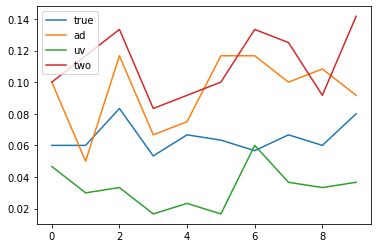

In [11]:
plt.plot(np.array(true_cs_value), label='true')
plt.plot(np.array(ad_side_cs_estimator), label='ad')
plt.plot(np.array(uv_side_cs_estimator), label='uv')
plt.plot(np.array(two_side_cs_estimator), label='two')
plt.legend()
plt.show()
